In [3]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math

import dataset_loader

%matplotlib inline

In [4]:
# Download mnist dataset from another place than in lab 1 (that one does not work anymore)
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz"

mnist_path = "./mnist.pkl.gz"

(train_data_pixels, train_data_classes), (dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

--2020-12-14 15:56:22--  https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz [following]
--2020-12-14 15:56:23--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.84.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.84.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  4.01MB/s    in 4.4s    

2020-12-14 15:56:28 (3.73 MB/s) - ‘mnist.pkl.gz’ saved [17051982/17051982]

In [5]:
train_data_pixels = torch.from_numpy(train_data_pixels).float()
train_data_classes = torch.from_numpy(train_data_classes).long()

dev_data_pixels = torch.from_numpy(dev_data_pixels).float()
dev_data_classes = torch.from_numpy(dev_data_classes).long()

In [6]:
print("Shape of the pixel tensor:", train_data_pixels.shape)
print("Shape of the class tensor:", train_data_classes.shape)

Shape of the pixel tensor: torch.Size([50000, 784])
Shape of the class tensor: torch.Size([50000])


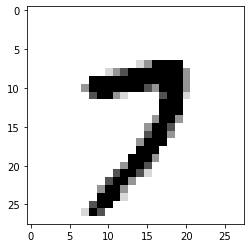

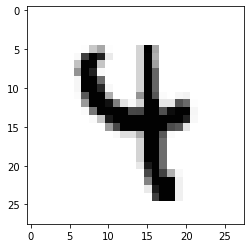

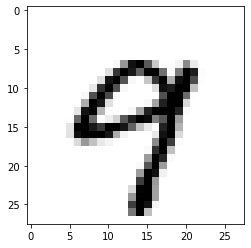

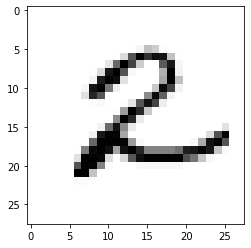

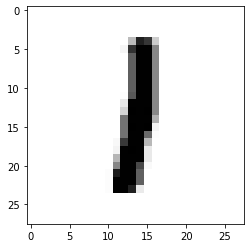

In [7]:
def display_images(images):
    images = images.detach().numpy()

    for i in range(images.shape[0]):
        plt.imshow(images[i].reshape(28,28), cmap='Greys')
        plt.show()
        
display_images(train_data_pixels[:5])

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal

class Encoder(nn.Module):
    def __init__(self, n_components):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*20*20, 250)
        self.mean_out = nn.Linear(250, n_components)
        self.logvar_out = nn.Linear(250, n_components)
        
    def forward(self, x):
        e1 = F.relu(self.conv1(x))
        e2 = F.relu(self.conv2(e1))
        e2 = e2.view(e2.size()[0], -1)
        e3 = F.relu(self.fc1(e2))
        mean = self.mean_out(e3)
        logvar = self.logvar_out(e3)
        return mean, logvar

    def sample(self, z_mean, z_logvar):
        eyes = torch.diag_embed(torch.ones_like(z_logvar))
        epsilon = MultivariateNormal(torch.zeros_like(z_mean), eyes).sample().to(device)
        return z_mean + epsilon*torch.exp(z_logvar)

In [ ]:
def loss_kl(z_mean, z_logvar):
    batch_size, n_components = z_mean.size()
    inner = torch.exp(z_logvar) + z_mean**2 - z_logvar
    return torch.sum(inner)/(2*batch_size) - n_components/2

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_components):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(n_components, 250)
        self.fc2 = nn.Linear(250, 16*20*20)
        self.convt1 = nn.ConvTranspose2d(16, 6, 5)
        self.mean_out = nn.ConvTranspose2d(6, 1, 5)
        self.logvar_out = nn.ConvTranspose2d(6, 1, 5)

        self.register_buffer('min_logvar', -6 * torch.ones(1))
        
    def forward(self, z):        
        d3 = F.relu(self.fc1(z))
        d2 = F.relu(self.fc2(d3))
    
        d2 = d2.view(-1, 16, 20, 20)
        d1 = F.relu(self.convt1(d2))

        mean = self.mean_out(d1)
        logvar = self.logvar_out(d1)
        logvar = self.min_logvar + F.softplus(logvar - self.min_logvar)
        return mean, logvar

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
    
def sample_prior(n_features, n_samples=1):
    return MultivariateNormal(torch.zeros(n_features), torch.eye(n_features)).sample((n_samples,))

class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.input_dim = input_dim
        
       
    def forward(self, batch):
        hid = self.fc1(batch)
        act = F.relu(hid)
        
        return self.fc2(act)
    
    # n_samples: number of "image output distribution" to compute
    def sample_distributions(self, n_samples):
        # first you must sample from the prior,
        # then you must pass the data through this network, i.e. self(z)
        
        # shape of z: (n_samples, input_dim)
        z = sample_prior(self.input_dim, n_samples)
        return torch.sigmoid(self(z))
        
    
    # sample images
    def sample_images(self, n_samples, argmax=False):
        # compute the output distributions for each image
        # probs shae: (n_samples, output_dim)
        probs = self.sample_distributions(n_samples)
        
        # then sample output pixels
        # there are two modes:
        # argmax=False: sample from the output distribution
        # argmax=True: instead of sampling, return the most probable value for each random variable
        # (check how the images are converted to binary images above!)
   
        if argmax:
            return 1*(probs >= 0.5)
        else:
            return torch.bernoulli(probs)

In [ ]:
dim_input = 28*28
latent_dim = 2 # we use only 2 dimensions so we can plot them!
hidden_dim = 400
n_epoch = 20
batch_dim = 256

encoder = GaussianEncoder(dim_input, hidden_dim, latent_dim)
decoder = GaussianPriorDecoder(latent_dim, hidden_dim, dim_input)

# we must pass both network parameters to the optimizer
# sometime its also useful to use two different optimizers,
# for example if we want to use different learning rates.
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data_pixels[i:i+batch_dim]
        
        # compute parameters of the approximate posterior
        mu, log_sigma_squared = encoder(batch)
        
        # for MC sampling of the reconstruction loss,
        # we use one sample from the approximate posterior.
        # you need to use the reparameterization trick for this!
        # in order to sample from the the N(0, 1) distribution,
        # you can use:
        # torch.empty_like(mu).normal_(mean=0.,std=1.)
        # (check the documentation if you don't understand this!)
        

        eyes = torch.diag_embed(torch.ones_like(log_sigma_squared))
        epsilon = MultivariateNormal(torch.zeros_like(mu), eyes).sample()
        z = mu + epsilon*torch.exp(log_sigma_squared)
        
        # reconstruction_logits: (batches, classes, output size)
        # note that the output of the network is in R,
        # to get Bernoulli parameters you must use the sigmoid.
        # For the reconstruction loss, you can either use:
        # - F.binary_cross_entropy_with_logits
        # - F.entropy_with_logits
        # Read the doc in order to understand the difference!
        # Warning: use the reduction="none" parameter
        reconstruction_logits = decoder(z)
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        )
        
        kl_div = KL_with_gaussian_prior(mu, log_sigma_squared)
        
        # loss shape: (batch dim,)
        # do you understand why we sum along this dimension only?
        # there is a minus sign before reconstruction because
        # the loss formula is -log etc, but in the elbo its +log
        elbo = -reconstruction_loss.sum(1) - kl_div
        
        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        # we want to maximize the ELBO,
        # but Pytorch does minimization,
        # so we define our loss as -ELBO
        # and we mean over instances in the dataset
        loss = -elbo.mean()
        loss.backward()
        
        # optimization trick :)
        # gradient clipping, so we don't take too big updates
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        optimizer.step()
        
    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0]
    )

In [ ]:
decoder.eval()

with torch.no_grad():
    # you can try true samples
    # or useing argmax
    samples = decoder.sample_distributions(5)
    display_images(samples)